<a href="https://colab.research.google.com/github/alik604/mathematical-finance/blob/master/XEG_ETF_decompotion_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XEG
https://www.blackrock.com/ca/investors/en/products/239839/ishares-sptsx-capped-energy-index-etf

### This notebook does not include good predictions. For that refer to code for an LSTM [here](https://github.com/alik604/mathematical-finance)

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
# !pip install pandas-datareader
# from pandas_datareader import data as pdr
# !pip install yfinance
import yfinance as yf


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas_datareader.data as web
import datetime
 
  
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

plt.style.use('fivethirtyeight')  
  
  
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
start = datetime.datetime(2020,3,21)
end = datetime.date.today()

Populating the interactive namespace from numpy and matplotlib


# Note
I consider only the top 10 and the ETF itself. Then I ignore the holdings that are <3%, but add `XOM` and `CVX`   
## Let's plot them

In [2]:
symbols = ['XEG.to', 'SU.to','CNQ.to','CVE.to','TOU.to','IMO.to'] # ,'PXT.to','CPG.to','PSK.to','ARX.to','WCP.to'
tmp = {
                      symbols[0]: yf.download(symbols[0], start, end)["Adj Close"], # XEG
                      symbols[1]: yf.download(symbols[1], start, end)["Adj Close"],
                      symbols[2]: yf.download(symbols[2], start, end)["Adj Close"],
                      symbols[3]: yf.download(symbols[3], start, end)["Adj Close"],
                      symbols[4]: yf.download(symbols[4], start, end)["Adj Close"],
                      symbols[5]: yf.download(symbols[5], start, end)["Adj Close"],
#                       symbols[6]: yf.download(symbols[6], start, end)["Adj Close"],
#                       symbols[7]: yf.download(symbols[7], start, end)["Adj Close"],
#                       symbols[8]: yf.download(symbols[8], start, end)["Adj Close"],
#                       symbols[9]: yf.download(symbols[9], start, end)["Adj Close"],
#                      symbols[10]: yf.download(symbols[10], start, end)["Adj Close"], 
                           "XOM": yf.download("XOM", start, end)["Adj Close"],
                           "CVX": yf.download("CVX", start, end)["Adj Close"],
}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'Many Oil stock'}, xlabel='Date', ylabel='Price (mixed currency)'>

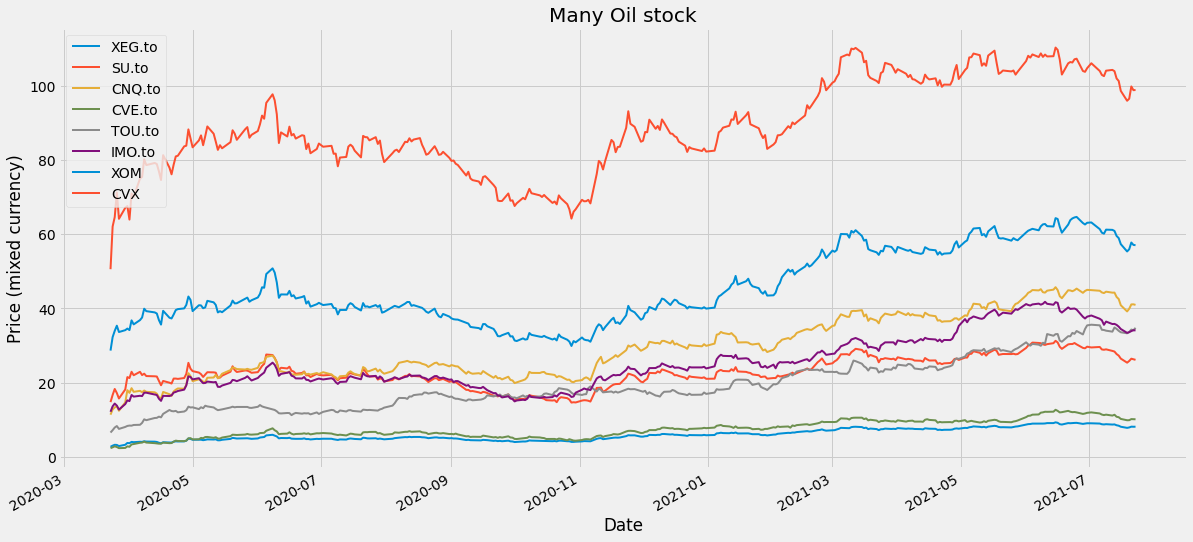

In [3]:
stocks = pd.DataFrame(tmp)
stocks=stocks.dropna()
stocks.plot(grid=True, figsize=(18,9), linewidth=2, title="Many Oil stock", ylabel="Price (mixed currency)")

In [4]:
print(f'From {str(stocks.index[0].date())} to {str(stocks.index[-1].date())}')

From 2020-03-23 to 2021-07-23


## let's do stuff to feel smart...

<AxesSubplot:xlabel='Date'>

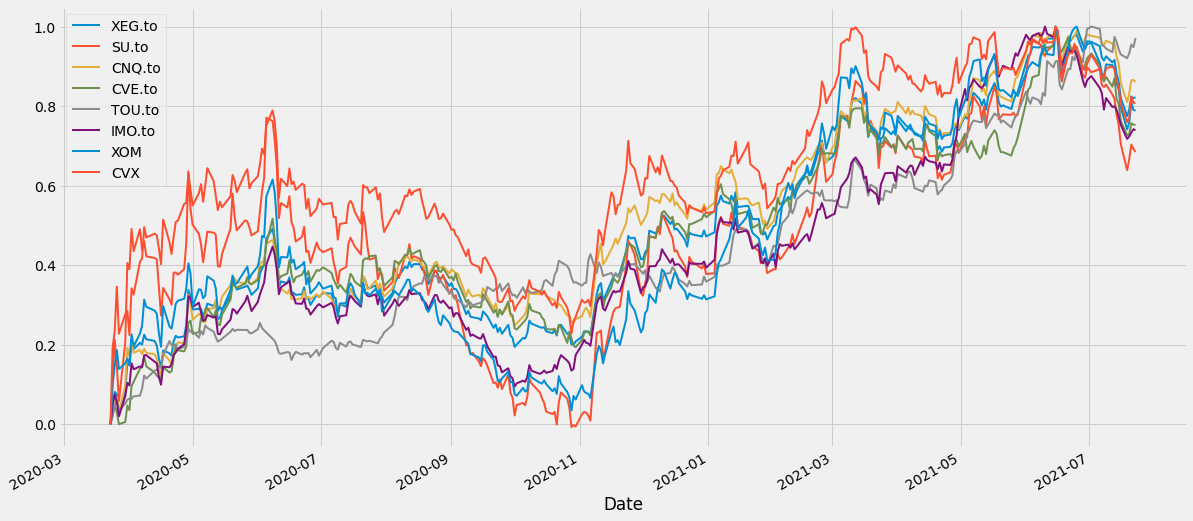

In [5]:
def normIt(myDf):
   return (myDf - myDf.mean()) / (myDf.max() - myDf.min())

stocks_norm = normIt(stocks)
stocks_norm = stocks_norm.dropna()
# for i in stocks_norm:
#   tmp = stocks_norm.loc[:, i]
#   offset = 0 - tmp[0]
#   stocks_norm.loc[:, i] += offset

stocks_norm -= stocks_norm.iloc[0]
stocks_norm.plot(grid=True, linewidth=2, figsize=(18, 9))

<AxesSubplot:title={'center':'XEG.to norm'}, xlabel='Date'>

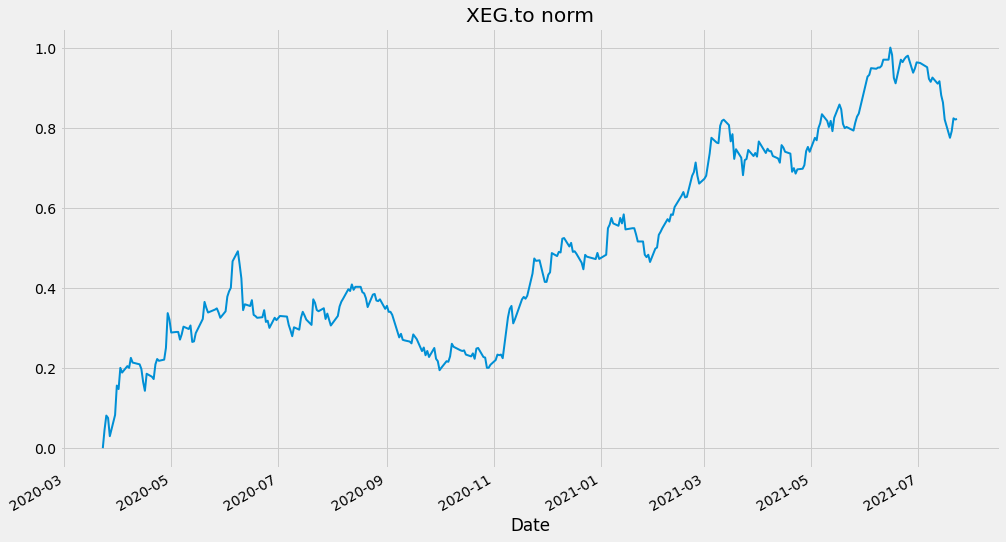

In [6]:
stocks_norm['XEG.to'].plot(grid=True, linewidth=2, title = "XEG.to norm")

In [7]:
stocks_norm.head(1) # yup all zeros

,XEG.to,SU.to,CNQ.to,CVE.to,TOU.to,IMO.to,XOM,CVX
Date,,,,,,,,
2020-03-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Correlations 

In [8]:
corrwith = stocks_norm.corr()
corrwith

,XEG.to,SU.to,CNQ.to,CVE.to,TOU.to,IMO.to,XOM,CVX
XEG.to,1.000000,0.888067,0.992545,0.984883,0.929657,0.977605,0.958861,0.936017
SU.to,0.888067,1.000000,0.839003,0.858020,0.703506,0.897030,0.947951,0.949383
CNQ.to,0.992545,0.839003,1.000000,0.979622,0.940696,0.963646,0.923413,0.907242
CVE.to,0.984883,0.858020,0.979622,1.000000,0.903149,0.948759,0.930364,0.917156
TOU.to,0.929657,0.703506,0.940696,0.903149,1.000000,0.905500,0.843431,0.781195
IMO.to,0.977605,0.897030,0.963646,0.948759,0.905500,1.000000,0.950034,0.926175
XOM,0.958861,0.947951,0.923413,0.930364,0.843431,0.950034,1.000000,0.964795
CVX,0.936017,0.949383,0.907242,0.917156,0.781195,0.926175,0.964795,1.000000


In [9]:
from scipy.stats import spearmanr

corrwith_spearman = spearmanr(stocks_norm)[0]
corrwith_spearman = pd.DataFrame(corrwith_spearman, index=stocks.columns, columns=stocks.columns)
corrwith_spearman

,XEG.to,SU.to,CNQ.to,CVE.to,TOU.to,IMO.to,XOM,CVX
XEG.to,1.000000,0.861651,0.988097,0.983955,0.873362,0.985796,0.921636,0.931506
SU.to,0.861651,1.000000,0.812823,0.841970,0.632630,0.879543,0.956739,0.944114
CNQ.to,0.988097,0.812823,1.000000,0.971170,0.901054,0.966520,0.875784,0.896501
CVE.to,0.983955,0.841970,0.971170,1.000000,0.848828,0.964551,0.911289,0.910562
TOU.to,0.873362,0.632630,0.901054,0.848828,1.000000,0.844372,0.717804,0.743744
IMO.to,0.985796,0.879543,0.966520,0.964551,0.844372,1.000000,0.931838,0.939497
XOM,0.921636,0.956739,0.875784,0.911289,0.717804,0.931838,1.000000,0.961637
CVX,0.931506,0.944114,0.896501,0.910562,0.743744,0.939497,0.961637,1.000000


In [10]:
# corr_cumSum = corrwith.cumsum()
corr_cumSum = corrwith_spearman.cumsum()
corr_cumSum

,XEG.to,SU.to,CNQ.to,CVE.to,TOU.to,IMO.to,XOM,CVX
XEG.to,1.000000,0.861651,0.988097,0.983955,0.873362,0.985796,0.921636,0.931506
SU.to,1.861651,1.861651,1.800920,1.825925,1.505992,1.865339,1.878375,1.875620
CNQ.to,2.849748,2.674473,2.800920,2.797096,2.407046,2.831859,2.754159,2.772121
CVE.to,3.833703,3.516444,3.772090,3.797096,3.255873,3.796410,3.665448,3.682683
TOU.to,4.707065,4.149074,4.673144,4.645923,4.255873,4.640782,4.383252,4.426427
IMO.to,5.692860,5.028618,5.639664,5.610474,5.100245,5.640782,5.315090,5.365924
XOM,6.614496,5.985356,6.515448,6.521763,5.818049,6.572620,6.315090,6.327561
CVX,7.546002,6.929471,7.411949,7.432325,6.561793,7.512117,7.276726,7.327561


In [11]:
keepThese = corr_cumSum.loc[:, corr_cumSum.iloc[-1] > corr_cumSum.iloc[-1].mean()*1.01]
keepThese

,XEG.to,CNQ.to,CVE.to,IMO.to,CVX
XEG.to,1.000000,0.988097,0.983955,0.985796,0.931506
SU.to,1.861651,1.800920,1.825925,1.865339,1.875620
CNQ.to,2.849748,2.800920,2.797096,2.831859,2.772121
CVE.to,3.833703,3.772090,3.797096,3.796410,3.682683
TOU.to,4.707065,4.673144,4.645923,4.640782,4.426427
IMO.to,5.692860,5.639664,5.610474,5.640782,5.365924
XOM,6.614496,6.515448,6.521763,6.572620,6.327561
CVX,7.546002,7.411949,7.432325,7.512117,7.327561


In [12]:
# keepThese = keepThese.loc[:, keepThese.iloc[-1] > keepThese.iloc[-1].mean()]
# keepThese

In [13]:
dropAllButThese = keepThese.columns.to_list()
corrwith[dropAllButThese]#.cumsum()

,XEG.to,CNQ.to,CVE.to,IMO.to,CVX
XEG.to,1.000000,0.992545,0.984883,0.977605,0.936017
SU.to,0.888067,0.839003,0.858020,0.897030,0.949383
CNQ.to,0.992545,1.000000,0.979622,0.963646,0.907242
CVE.to,0.984883,0.979622,1.000000,0.948759,0.917156
TOU.to,0.929657,0.940696,0.903149,0.905500,0.781195
IMO.to,0.977605,0.963646,0.948759,1.000000,0.926175
XOM,0.958861,0.923413,0.930364,0.950034,0.964795
CVX,0.936017,0.907242,0.917156,0.926175,1.000000


<AxesSubplot:xlabel='Date'>

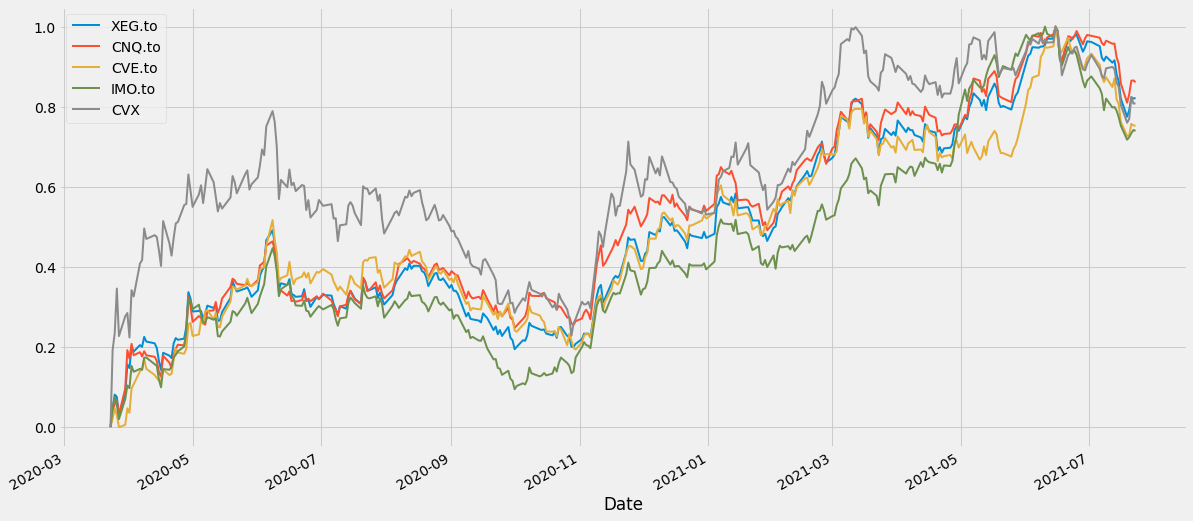

In [14]:
stocks_main_norm = stocks_norm[dropAllButThese]
stocks_main_norm.plot(grid=True, linewidth=2, figsize=(18, 9))

In [18]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import BayesianRidge

# from fbprophet import Prophet
from sklearn.svm import SVR 
import xgboost

In [19]:
# help(xgboost.XGBRegressor)

## XGBRegressor seems to do only 1D, so i dont recommend it...

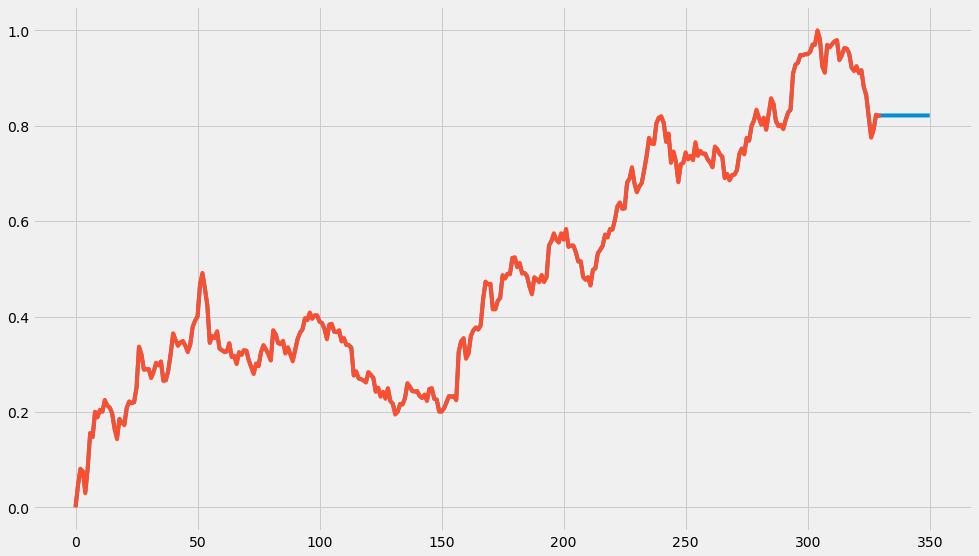

In [20]:
df = stocks_main_norm
x = np.arange(df.shape[0]).reshape(-1, 1)
x_pred = np.arange(df.shape[0], df.shape[0]+10).reshape(-1, 1)
y = df["XEG.to"].values # df.values

# low learning_rate is bad. low-med max_depth is fine (10ish), n_estimators=50 is fine. 
xg_reg = xgboost.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.5, max_depth = 100, n_estimators = 500)


_ = xg_reg.fit(x,y)
y_pred = xg_reg.predict(np.array(range(0, df.shape[0]+20)))

plt.plot(y_pred)
plt.plot(x, y)


## These to multidimensional regression, i recommend these

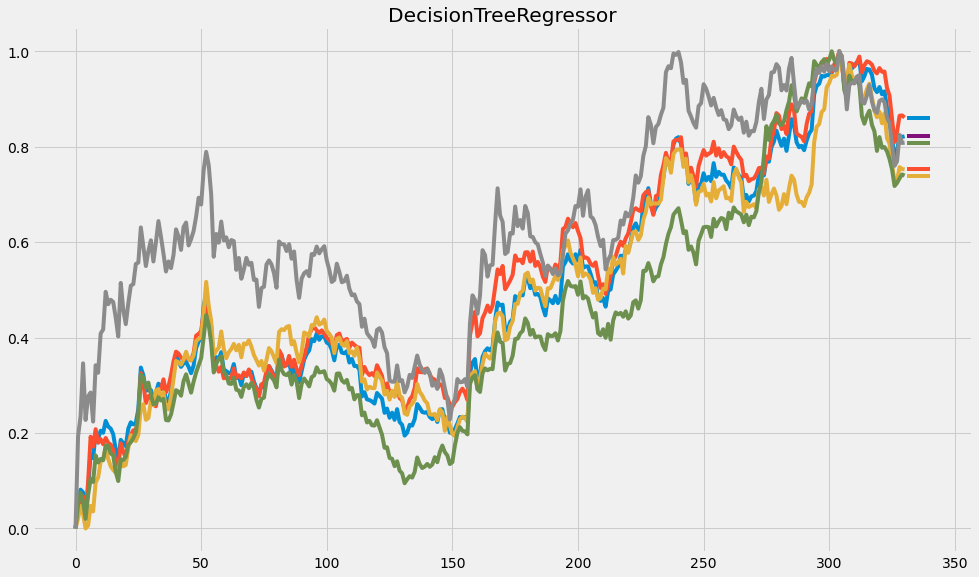

Do only XEG.to


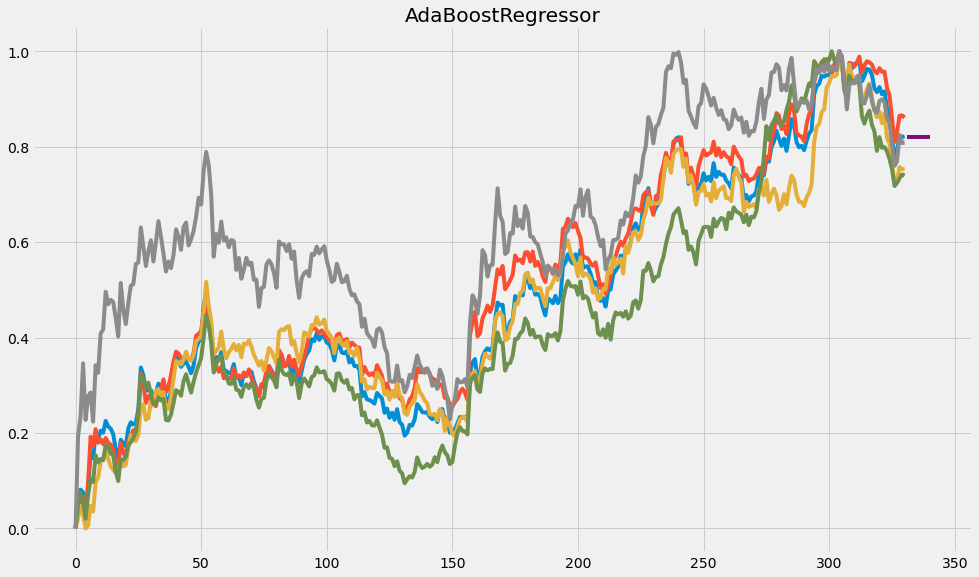

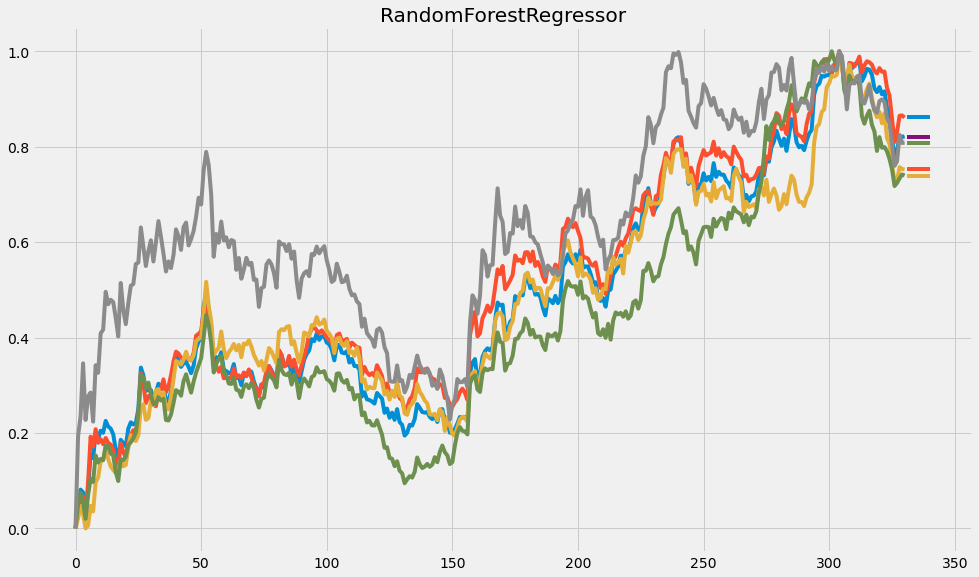

Do only XEG.to


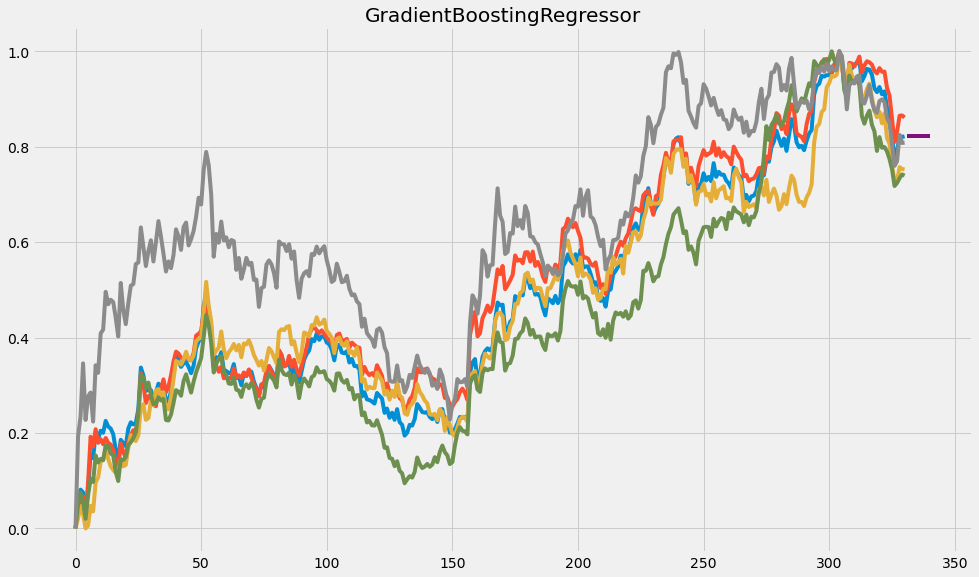

Do only XEG.to


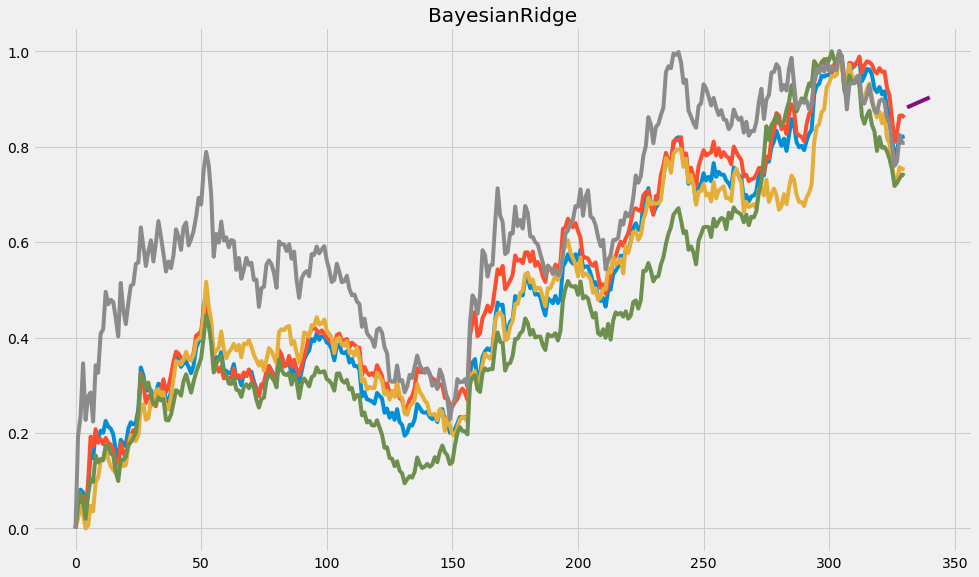

In [21]:
x = np.arange(df.shape[0]).reshape(-1, 1)
x_pred = np.arange(df.shape[0], df.shape[0]+10).reshape(-1, 1)

y = df.values
# y = df["XEG.to"].values 

regs = [DecisionTreeRegressor(),
        AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), loss='square'),
        RandomForestRegressor(200),
        GradientBoostingRegressor(n_estimators=150, max_depth=5),
        BayesianRidge(n_iter=500, tol=0.0015, normalize=True)]
for reg in regs:
  try:
    _ = reg.fit(x, y)
  except:
    print(f'Do only {"XEG.to"}')
    _ = reg.fit(x, stocks_main_norm["XEG.to"].values)

  
  y_pred = reg.predict(x_pred)

  _ = plt.plot(x, y)
  _ = plt.plot(x_pred, y_pred)
  _ = plt.title(str(type(reg)).split(".")[-1][:-2])
  plt.show()

In [22]:
# svr_rbf = SVR(kernel='rbf')
# svr_rbf.fit(x, y)

# plt.scatter(dates, prices, c='k', label='Data')
# plt.plot(dates, svr_lin.predict(dates), c='g', label='Linear model')
# plt.plot(dates, svr_rbf.predict(dates), c='r', label='RBF model')    
# plt.plot(dates, svr_poly.predict(dates), c='b', label='Polynomial model')

# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Support Vector Regression')
# plt.legend()
# plt.show()

# Prediction



In [23]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
  

model = ARIMA(quickDF["XEG.to"], order=(5,1,0))
model_fit = model.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

c:\users\kali\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


NameError: name 'quickDF' is not defined

In [ ]:
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

X = quickDF["XEG.to"].values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test+10)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.5f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# ARIMA to forecast 

In [ ]:
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

X = quickDF["XEG.to"].values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
#print (history==train) #True 
for t in range(len(test)+10):
    model = ARIMA(history[-1*len(test):], order=(5,1,0)) # changed*
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    try:
      obs = test[t]
    except IndexError:
      obs = yhat
	

    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
 
# error = mean_squared_error(test, predictions)
# print('Test MSE: %.5f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [24]:
import numpy as np

#stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change = stocks.apply(lambda x: (x) - (x.shift(1))) # shift moves dates back by 1.
stock_change=stock_change.dropna()
stock_change.head()

,XEG.to,SU.to,CNQ.to,CVE.to,TOU.to,IMO.to,XOM,CVX
Date,,,,,,,,
2020-03-24,0.304060,1.923544,1.418244,0.219300,0.636164,1.463562,3.632458,11.499897
2020-03-25,0.231401,1.617308,0.541176,0.269141,0.713274,0.755696,1.684219,2.536869
2020-03-26,-0.038728,-1.090967,0.354560,-0.179427,0.404833,-0.545250,1.392899,6.631317
2020-03-27,-0.300144,-1.473758,-1.240965,-0.309014,-0.771110,-1.080931,-1.702431,-7.088333
2020-03-30,0.348554,2.430745,2.239335,0.059809,0.530138,1.482693,0.500713,2.956589


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

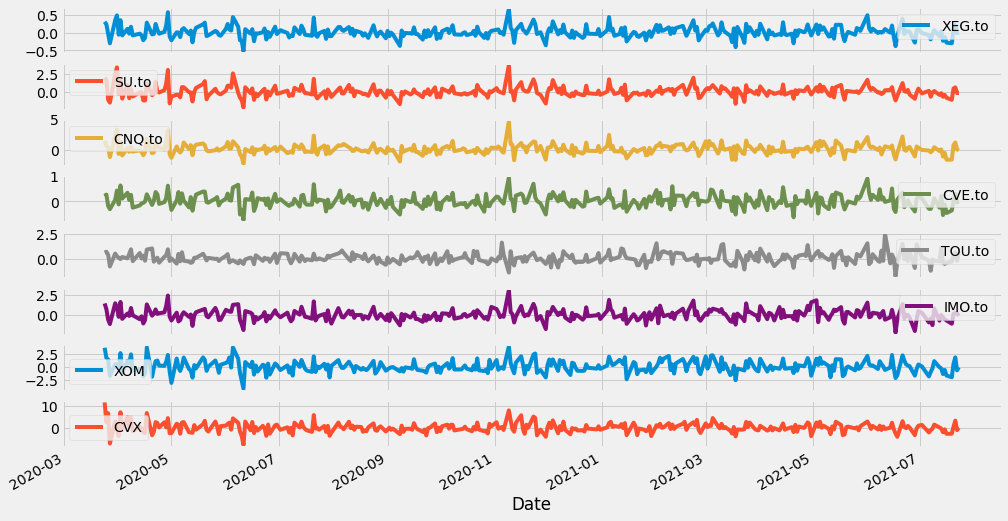

In [25]:
stock_change.plot(grid = True,subplots=True)#.axhline(y = 0, color = "black", lw = 2)

[*********************100%***********************]  1 of 1 completed


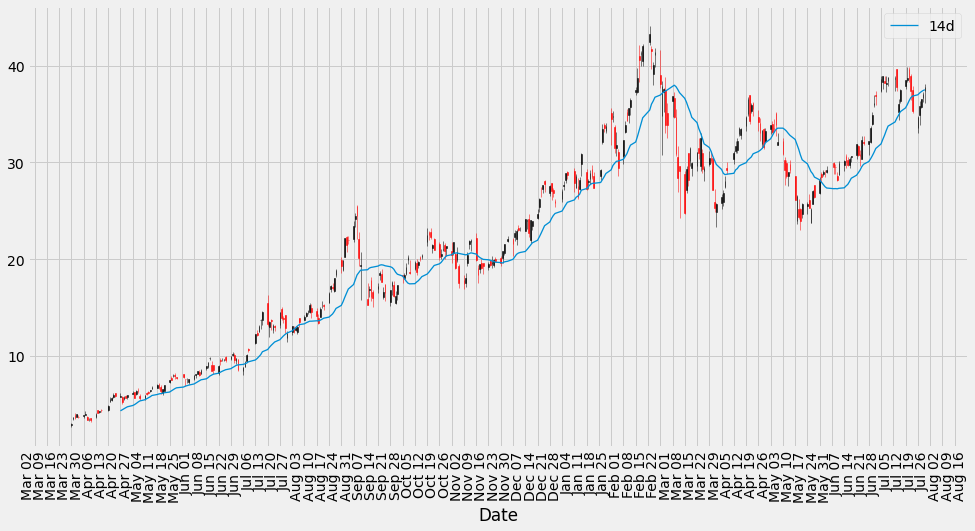

In [35]:
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from mplfinance.original_flavor import candlestick_ohlc

def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
 
    plt.show()
 
#pandas_candlestick_ohlc(apple)
FNGU = yf.download("FNGU", start, end)

FNGU["14d"] = np.round(FNGU["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(FNGU.loc['2019-01-04':], otherseries = "14d") # FNGU.loc['201-01-04':'2016-08-07',:]

does the PCA of the lesser CORR fetures assist in forcasting an index? 